In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.calibration import CalibrationDisplay
import pandas as pd
import numpy as np

import sys
sys.path.append('../')

from src.bet_sizing import SimultaneousKelly

In [2]:
train_df = pd.read_csv("../data/processed/train.csv").drop(columns=["BOUT_ID", "EVENT_ID", "DATE", "BOUT_ORDINAL"])
test_df = pd.read_csv("../data/processed/test.csv").drop(columns=["BOUT_ID", "EVENT_ID", "DATE", "BOUT_ORDINAL"])
test_df = test_df.loc[test_df["RED_WIN"].notnull()]

In [3]:
X_train = train_df.drop(columns=["RED_WIN"])
y_train = train_df["RED_WIN"]
X_test = test_df.drop(columns=["RED_WIN"])
y_test = test_df["RED_WIN"]

In [4]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [34]:
param_grid = {
    "max_depth": [3, 5, 7, 12, 15, 20],
    "max_leaf_nodes": [None, 50, 70, 80, 90, 100]
}

clf = RandomForestClassifier(n_estimators=200, criterion="gini", max_features="sqrt", random_state=0, n_jobs=-1)
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring="neg_log_loss", n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                              random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 12, 15, 20],
                         'max_leaf_nodes': [None, 50, 70, 80, 90, 100]},
             scoring='neg_log_loss', verbose=2)

In [39]:
grid_search.best_params_

{'max_depth': 20, 'max_leaf_nodes': 70}

In [40]:
y_pred_train = grid_search.predict_proba(X_train)[:, 1]
log_loss(y_train, y_pred_train) # type: ignore

0.5222304510047173

In [41]:
y_pred_test = grid_search.predict_proba(X_test)[:, 1] # type: ignore
log_loss(y_test, y_pred_test) # type: ignore

0.6280646535778013

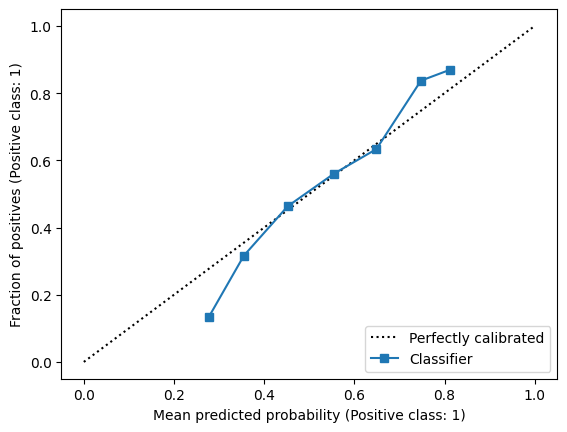

In [42]:
disp = CalibrationDisplay.from_predictions(y_test, y_pred_test, n_bins=10)